# **XGBoost**

---

## 0. Importing dependencies

In [24]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [25]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [26]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Zimbabwe', 'Country_Slovakia', 'Country_El Salvador', 'Country_Philippines', 'Country_Peru', 'Country_Kenya', 'Country_Venezuela', 'Country_Andorra', 'Country_Croatia', 'Country_North Macedonia', 'Country_Bosnia-Herz.', 'Country_Jordan', 'Country_Cyprus', 'Country_Nomadic', 'Country_Kosovo', 'Country_Tanzania', 'Country_Georgia', 'Country_Yemen', 'Country_Sri Lanka', 'Country_Malta', 'Country_United Arab Emirates', 'Country_Serbia', 'Country_Azerbaijan', 'Country_Paraguay', 'Country_Angola', 'Country_Armenia', 'Country_New Zealand', 'Country_Viet Nam', 'Country_Uzbekistan', 'Country_Latvia', 'Country_Estonia', 'Ethnicity_North American / Central American', 'Country_Costa Rica', 'Country_Botswana', 'Country_Saudi Arabia', 'Country_Mongolia', 'Country_Bangladesh', 'Country_Lebanon'}
Columns in the test set that aren't in the train set: {'Country_Barbados', 'Country_Republic of Korea', 'Country_Qatar', 'Country_Senegal', 'Cou

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [27]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]


# Upon exploration in MLR results, we found that the following columns are adding noise to the model
# as they correspond to values mainly from USA with non-sense relationship mainly Work_experience - Annual_salary
# Hence, we will remove them from the baseline model
baseline_train_df.drop([2153,359, 281, 297, 432, 601, 309, 239, 409, 454], inplace=True)
baseline_test_df.drop(538, inplace=True)

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Colombia,Country_Czech Republic,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Hungary,Country_India,Country_Indonesia,Country_Iran,Country_Ireland,Country_Israel,Country_Italy,Country_Japan,Country_Kazakhstan,Country_Lithuania,Country_Luxembourg,Country_Malaysia,Country_Mexico,Country_Morocco,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Pakistan,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Singapore,Country_Slovenia,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_Turkey,Country_UK & Northern Ireland,Country_USA,Country_Ukraine,Country_Uruguay,Academic researcher,Blockchain,Cloud infrastructure engineer,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, game or graphics","Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,12.2,62820.0


In [28]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = baseline_train_df['Annual_salary']
y_test = baseline_test_df['Annual_salary']

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2248, 92)
(2248,)

(552, 92)
(552,)


---

### 2.2. Identifying the target

In [29]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = train_df['Annual_salary']
# y_test = test_df['Annual_salary']
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importnce
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [31]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    "n_estimators": randint(300, 700),
    "learning_rate": uniform(0.01, 0.1),
    "max_depth": randint(1, 5),
    "min_child_weight": randint(1, 7),
    "gamma": uniform(0, 1),
    "subsample": uniform(0.4, 0.6),
    "colsample_bytree": uniform(0.4, 0.6),
}

scorer = {'r2': make_scorer(r2_score, greater_is_better=True), 
          'rmse': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END colsample_bytree=0.6247240713084175, gamma=0.9507143064099162, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=5, n_estimators=402, subsample=0.6674996517121548; total time=   1.0s
[CV] END colsample_bytree=0.6247240713084175, gamma=0.9507143064099162, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=5, n_estimators=402, subsample=0.6674996517121548; total time=   1.0s
[CV] END colsample_bytree=0.6247240713084175, gamma=0.9507143064099162, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=5, n_estimators=402, subsample=0.6674996517121548; total time=   1.0s
[CV] END colsample_bytree=0.6247240713084175, gamma=0.9507143064099162, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=5, n_estimators=402, subsample=0.6674996517121548; total time=   1.0s
[CV] END colsample_bytree=0.45998494949080176, gamma=0.45924889196586716, learning_rate=0.04337086111390219, max_de

#### 3.1.1. CV results

Let's look at results per parameter combination

In [32]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.629922,0.606293,30587.594183,31489.880987
1,0.749369,0.620773,25172.291010,30919.114848
2,0.667409,0.605821,28997.537247,31517.915084
3,0.723269,0.624211,26450.163955,30776.827046
4,0.714614,0.623171,26861.348954,30817.769449
5,0.667626,0.623072,28987.741607,30815.621851
6,0.740803,0.622664,25598.763556,30842.074645
7,0.560299,0.551307,33341.173223,33627.052650
8,0.684075,0.624952,28260.976699,30742.450573
9,0.773756,0.606724,23915.585728,31487.587945


Now, the average of folds:

In [33]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  
mean_train_r2 = np.mean(df_cv_results['mean_train_r2']) 
mean_train_rmse = np.mean(df_cv_results['mean_train_rmse'])
 
print(f"Mean CV Train R2: {mean_train_r2}")
print(f"Mean CV Train RMSE: {mean_train_rmse}")
print('-'*20)
print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Train R2: 0.6911143534855575
Mean CV Train RMSE: 27817.317616218294
--------------------
Mean CV Test R2: 0.6108986950672434
Mean CV Test RMSE: 31303.629507824116


In [34]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = pd.DataFrame([{
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }])
        results_df = pd.concat([results_df, fold_results], ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
print(results_df.to_markdown())

|   Fold |   train_r2 |   test_r2 |   train_rmse |   test_rmse |
|-------:|-----------:|----------:|-------------:|------------:|
|      1 |   0.627013 |  0.613181 |      30636.5 |     31416   |
|      2 |   0.749882 |  0.625006 |      25087.9 |     30932   |
|      3 |   0.665705 |  0.607405 |      29003.9 |     31649.7 |
|      4 |   0.720978 |  0.629134 |      26497.9 |     30761.3 |
|      5 |   0.713883 |  0.629944 |      26832.7 |     30727.7 |
|      6 |   0.666569 |  0.626362 |      28966.5 |     30876.1 |
|      7 |   0.739736 |  0.629838 |      25591.7 |     30732.1 |
|      8 |   0.557364 |  0.554649 |      33374.5 |     33709.1 |
|      9 |   0.682837 |  0.63158  |      28251   |     30659.7 |
|     10 |   0.772184 |  0.615477 |      23943.3 |     31322.6 |
|     11 |   0.624762 |  0.627142 |      30586.9 |     31357.8 |
|     12 |   0.747315 |  0.629614 |      25099.9 |     31253.6 |
|     13 |   0.663851 |  0.625237 |      28950   |     31437.8 |
|     14 |   0.720615 |  

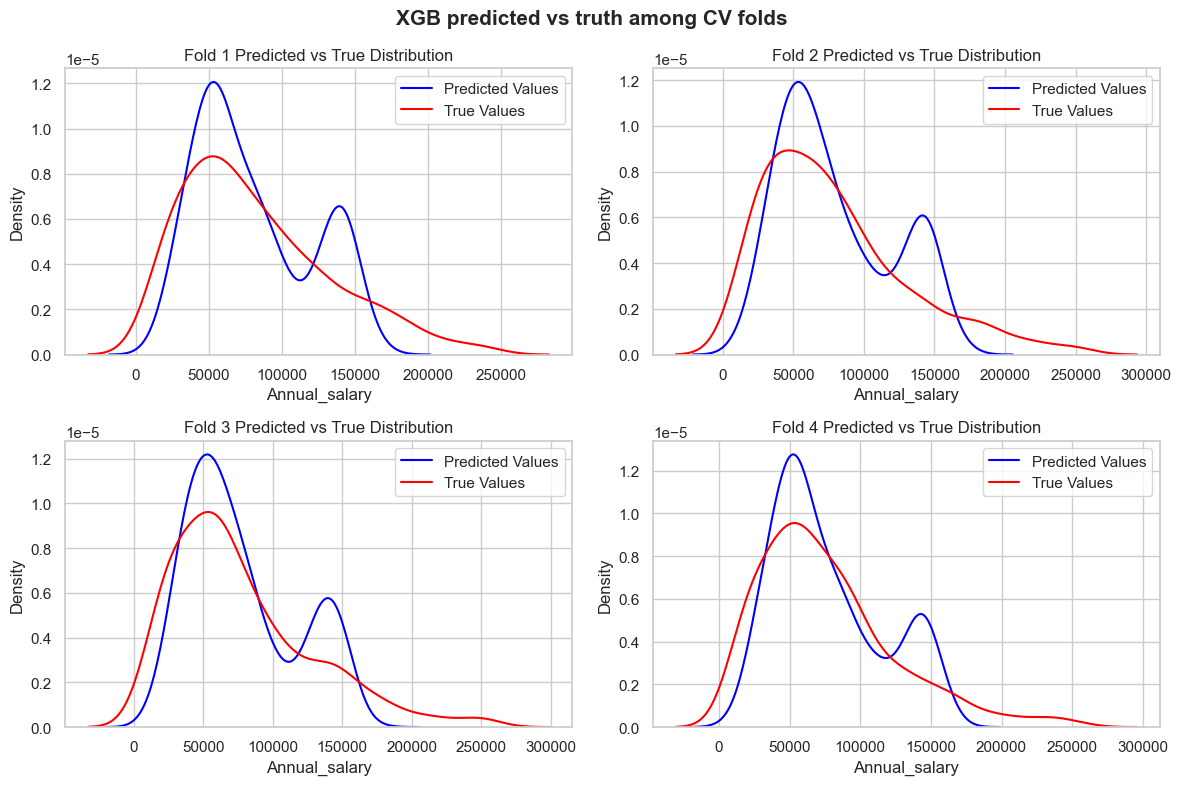

In [35]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    # Extrae los datos para este fold específico
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    # Realiza las predicciones para este fold
    y_fold_pred = clf.predict(X_fold_test)

    # Crear un subplot para cada fold
    plt.subplot(2, 2, fold_num)
    sns.kdeplot(y_fold_pred, color='blue', label='Predicted Values')
    sns.kdeplot(y_fold_true, color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('XGB predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [36]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results


Train set metrics:
R^2: 0.6784499496353372
RMSE: 28518.075737795094
Adjusted R^2: 0.664722522891231


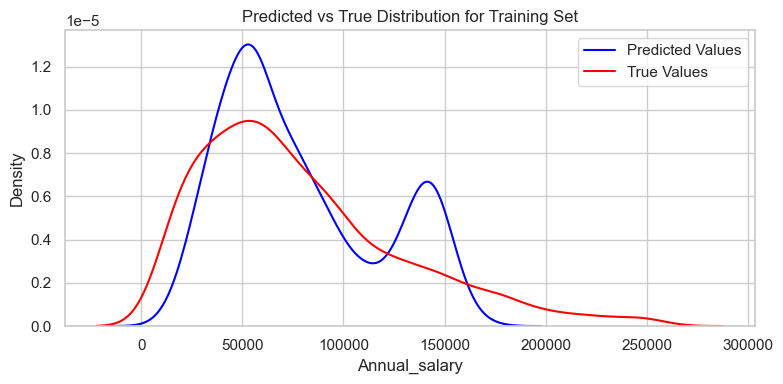

In [37]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")


y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(y_train_pred, color='blue', label='Predicted Values')
sns.kdeplot(y_train, color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6512492342133853
RMSE: 29253.336377778603
Adjusted R^2: 0.5813471199380725


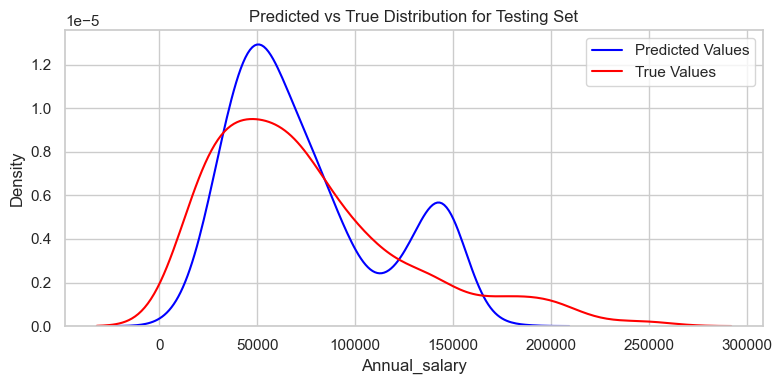

In [38]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")

y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(y_test_pred, color='blue', label='Predicted Values')
sns.kdeplot(y_test, color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

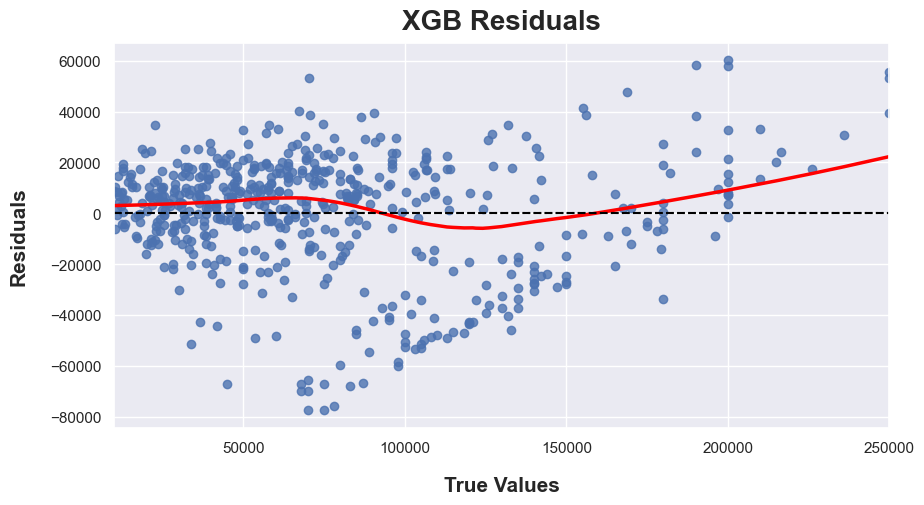

In [40]:
sns.set_theme(style='darkgrid')

residuals = y_test - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('XGB Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/xgb-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 1000x600 with 0 Axes>

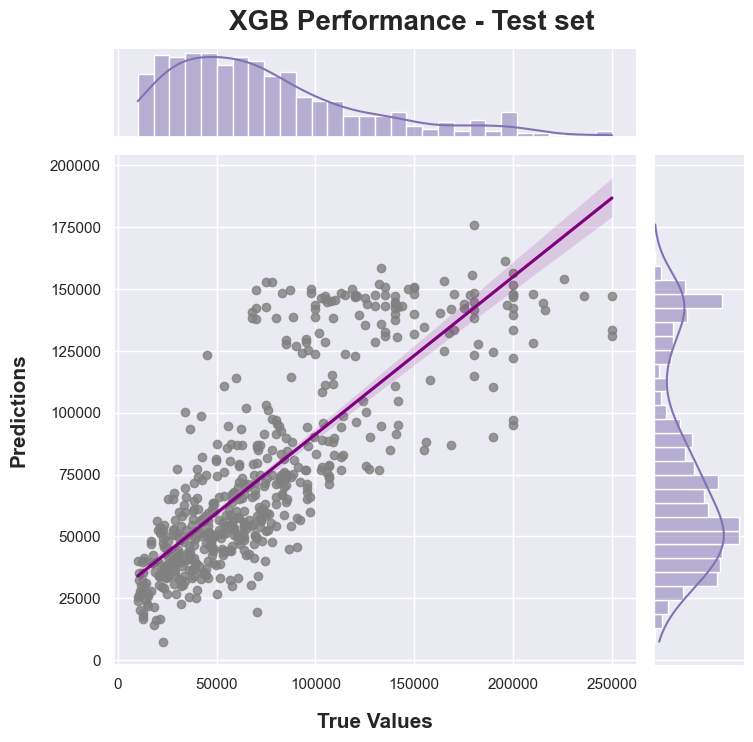

In [41]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=y_test, y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('XGB Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/xgb-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [42]:
df_cv_results.to_csv("../../output/xgb-cv-results.csv")

Saving train and test sets predictions

In [43]:
np.savetxt("../../output/xgb-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/xgb-test-predictions.csv", y_pred_test, delimiter=",")

## 7. Others

For XGB, let's also see the feature importance

### 7.1. Gain

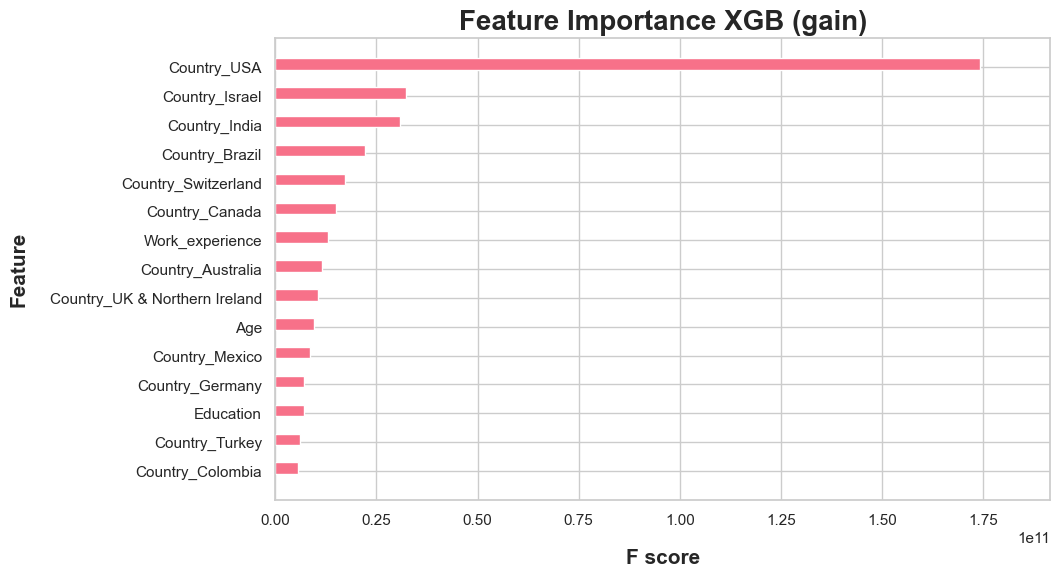

In [44]:
sns.set_theme(style='whitegrid', palette='husl') 

fig, ax = plt.subplots(figsize=(10, 6))

xgb.plot_importance(clf.best_estimator_, importance_type='gain', max_num_features=15, ax=ax, title='Gain Importance', show_values=False)

for bar in ax.patches:
    bar.set_height(bar.get_height() * 2)  # Multiplica el grosor de las barras por 2

# Ajusta los títulos y etiquetas
ax.set_title('Feature Importance XGB (gain)', weight='bold', fontsize=20)
ax.set_xlabel('F score', weight='bold', labelpad=15, fontsize=15)
ax.set_ylabel('Feature', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/xgb-test-fscore-gain.pdf")
plt.show()

### 7.2. Weight

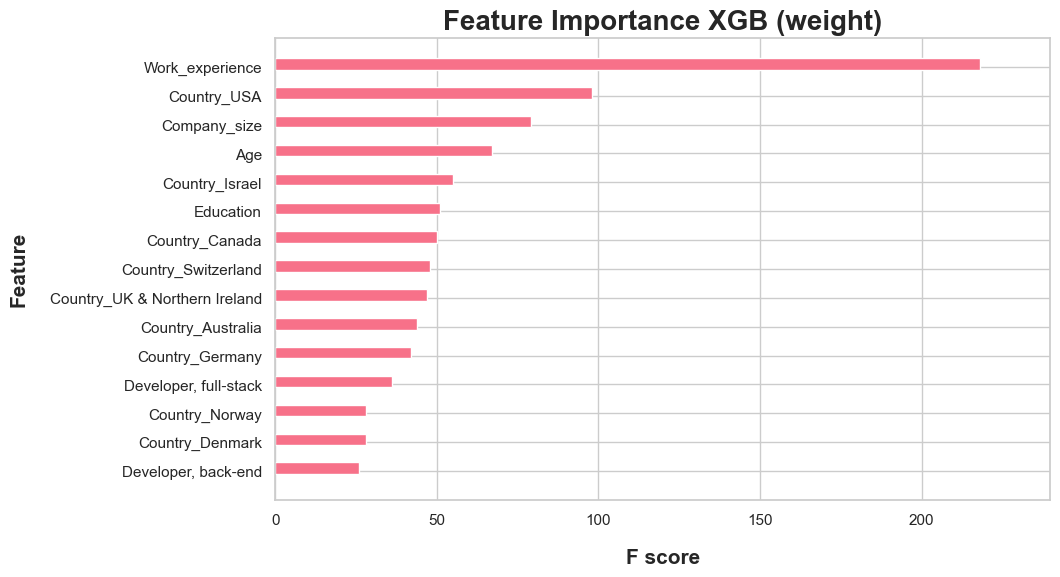

In [45]:
sns.set_theme(style='whitegrid', palette='husl') 

fig, ax = plt.subplots(figsize=(10, 6))

xgb.plot_importance(clf.best_estimator_, importance_type='weight', max_num_features=15, ax=ax, title='Gain Importance', show_values=False)

for bar in ax.patches:
    bar.set_height(bar.get_height() * 2)  # Multiplica el grosor de las barras por 2

# Ajusta los títulos y etiquetas
ax.set_title('Feature Importance XGB (weight)', weight='bold', fontsize=20)
ax.set_xlabel('F score', weight='bold', labelpad=15, fontsize=15)
ax.set_ylabel('Feature', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/xgb-test-fscore-weight.pdf")

plt.show()


In [46]:
pd.set_option('display.max_colwidth', None)


df_cv_results[['params', 'mean_train_r2', 'mean_test_r2' ]]

,params,mean_train_r2,mean_test_r2
0,"{'colsample_bytree': 0.6247240713084175, 'gamma': 0.9507143064099162, 'learning_rate': 0.0831993941811405, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 402, 'subsample': 0.6674996517121548}",0.629922,0.606293
1,"{'colsample_bytree': 0.45998494949080176, 'gamma': 0.45924889196586716, 'learning_rate': 0.04337086111390219, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 449, 'subsample': 0.4338469474162602}",0.749369,0.620773
2,"{'colsample_bytree': 0.8331992633600949, 'gamma': 0.9385527090157502, 'learning_rate': 0.010077876584101433, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 460, 'subsample': 0.5825453457757226}",0.667409,0.605821
3,"{'colsample_bytree': 0.7148538589793427, 'gamma': 0.43194501864211576, 'learning_rate': 0.039122914019804195, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 487, 'subsample': 0.619817105976215}",0.723269,0.624211
4,"{'colsample_bytree': 0.6736419905302216, 'gamma': 0.7851759613930136, 'learning_rate': 0.029967378215835977, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 619, 'subsample': 0.680057735948788}",0.714614,0.623171
5,"{'colsample_bytree': 0.9159642440417923, 'gamma': 0.6803075385877797, 'learning_rate': 0.05504992519695431, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 388, 'subsample': 0.9793792198447356}",0.667626,0.623072
6,"{'colsample_bytree': 0.8850384088698766, 'gamma': 0.3046137691733707, 'learning_rate': 0.01976721140063839, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 666, 'subsample': 0.809958111295275}",0.740803,0.622664
7,"{'colsample_bytree': 0.7659979946695725, 'gamma': 0.8331949117361643, 'learning_rate': 0.02733646535077721, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 349, 'subsample': 0.7975133706123891}",0.560299,0.551307
8,"{'colsample_bytree': 0.5870266456536466, 'gamma': 0.5200680211778108, 'learning_rate': 0.06467102793432797, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 490, 'subsample': 0.9053708647569991}",0.684075,0.624952
9,"{'colsample_bytree': 0.6698524800218595, 'gamma': 0.3951502360018144, 'learning_rate': 0.10266588657937942, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 514, 'subsample': 0.7125005560154942}",0.773756,0.606724
